In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Regional Mappings

In [69]:
# apply region mapping
mapping = pd.read_csv('region_mapping.csv').set_index('cntry_code')
regions = sorted(set(mapping.wbregion2.dropna()))
palette = sns.color_palette(sns.hls_palette(n_colors=len(regions), l=.4))
region_colors = {r: palette.pop() for r in regions}

# Projected Values

In [93]:
# inc and ineq
pdf = pd.read_csv('../econ/nbs/data/projections_ur_income.csv', index_col=[0, 1])
pdf = pdf[['iso', 'gdppc', 'gini']].reset_index()
pdf = pdf[pdf.year <= 2050]

In [94]:
# std of ineq
sdf = pd.read_csv('adjusted_multi_single.csv') # result of smooth.ipynb
sdf.columns = ['scenario'] + list(sdf.columns[1:])
sdf.columns.name = 'iso'
sdf = sdf[sdf.scenario == 'std']
sdf = sdf.set_index(['scenario', 'year']).stack().reset_index()
sdf = sdf.drop('scenario', axis=1)
sdf.columns = list(sdf.columns)[:-1] + ['std']

In [95]:
# reduce
pdf = pdf[pdf.iso.isin(sdf.iso)]
sdf = sdf[sdf.year.isin(pdf.year)]

In [96]:
# combine
proj = pdf.set_index(['scenario', 'iso', 'year']).sort_index()
proj['std'] = np.nan
proj.loc['SSP1']['std'] = sdf.set_index(['iso', 'year'])
proj.loc['SSP4']['std'] = sdf.set_index(['iso', 'year'])
proj['var'] = proj['std'] ** 2
proj.head()

gdppc       gini        std         var
scenario iso year                                                
SSP1     AUT 2015  44465.407084  26.822889  12.513879  156.597168
             2020  47874.461666  27.286419  12.618526  159.227198
             2025  51148.215662  27.477064  12.769838  163.068763
             2030  54773.374098  27.515633  12.988577  168.703132
             2035  58834.424443  27.395164  13.270892  176.116574

# Historical Values

In [97]:
hist = pd.read_csv('Hist_GDP_Gini_Data.csv')
hist.columns = ['iso', 'year', 'gini', 'gdppc']
hist = hist[hist.year >= 2000]
hist = hist[hist.iso.isin(set(proj.index.levels[1]))]
hist = hist.groupby(['iso', 'year']).median()
hist = hist.interpolate()
hist = hist.reset_index()
hist = hist[hist.year <= 2010]
hist.head()

,iso,year,gini,gdppc
0,AUT,2000,24.0,31775.73317
1,AUT,2001,24.0,31925.73341
2,AUT,2002,25.5,32307.13268
3,AUT,2003,27.0,32428.53067
4,AUT,2004,26.0,33062.53146


# Regional Aggregation

In [98]:
proj = proj.reset_index()
proj['region'] = proj.iso.apply(lambda i: mapping.loc[i])
hist['region'] = hist.iso.apply(lambda i: mapping.loc[i])

In [99]:
grp = proj.groupby(['scenario', 'region', 'year'])
rproj = grp[['gdppc', 'gini']].median()
rproj['std'] = grp['var'].mean() ** 0.5
rproj.tail()

gdppc       gini  std
scenario region     year                              
SSP5     South Asia 2030  10789.617539  37.531788  NaN
                    2035  15020.486251  38.728878  NaN
                    2040  20180.782641  39.188343  NaN
                    2045  26161.879695  38.690628  NaN
                    2050  32826.649179  37.134880  NaN

In [100]:
rhist = hist.groupby(['region', 'year']).median()
rhist['std'] = 0
rhist.head()

gini         gdppc  std
region             year                          
Advanced Economies 2000  29.50  27963.513200    0
                   2001  28.50  28367.782785    0
                   2002  28.88  28456.205215    0
                   2003  29.02  28733.695045    0
                   2004  28.00  29541.601990    0

# Plots

In [101]:
rdata = rproj.reset_index().set_index('scenario')
hdata = rhist.reset_index()

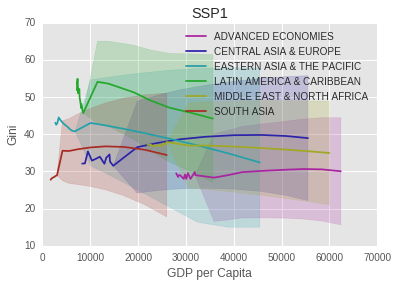

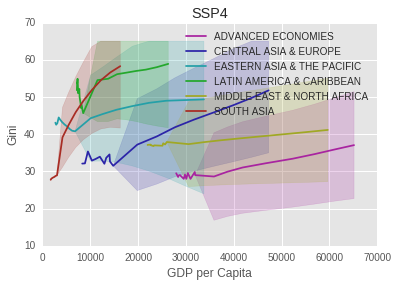

In [102]:
regions = sorted(set(set(hdata.region)))
palette = sns.color_palette(sns.hls_palette(n_colors=len(regions), l=.4))
colors = {i: palette.pop() for i in regions}
                            
for ssp in ['SSP1', 'SSP4']:
    df = pd.concat([rdata.loc[ssp], hdata])
    df = df.set_index('region')
    for iso in sorted(set(df.index)):
        data = df.loc[iso].sort_values(by='gdppc')
        plt.plot(data.gdppc, data.gini, label=iso.upper(), c=colors[iso])
        lb = (data.gini - data['std']).apply(lambda x: max(x, 15))
        ub = (data.gini + data['std']).apply(lambda x: min(x, 65))
        plt.fill_between(data.gdppc, lb, ub, alpha=.2, color=colors[iso])
    plt.legend(loc='best')
    plt.xlabel('GDP per Capita')
    plt.title(ssp)
    plt.ylabel('Gini')
    plt.show()
    plt.clf()